Class

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sys import stdout
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from matplotlib.ticker import MaxNLocator
from sklearn.cross_decomposition import PLSRegression

class fixed_size_GA():

    def __init__(self,N:100,m:10, crossp=0.7,mutp = 0.7):
        '''
        Parameters:
        N (int) Number of individuals per population (population size).
        m (int): Number of fixed components.
        crossp (float) crossover probability.
        mutp (float) mutation probability.
        '''
        self._N = N
        self._m = m
        self._crossp = crossp
        self._mutp = mutp
        
        self._NEGNRMSEPiqrscorer = make_scorer(self._NEGNRMSEPiqr)
        
        df = pd.read_excel("datasets/Dataset_2.xlsx",sheet_name="preproc")
        self._X = (df.iloc[:,14:]).values
        self._Y = (df.iloc[:,7]).values
        self._n = self._X.shape[1]
        random_cv = np.random.seed(777)
        self._trials = 100
        self._seeds = np.random.choice(self._trials + 1, size=self._trials, replace= False)


        self._create_initial_population()

    def _create_initial_population(self):
        """
        This function create the initial pseudorandom population with
        a fixed size of 1s..

        Parameters:

        Returns:
        Initial population (list): list of bit string consisting of the initial population 
        """
        C = np.zeros((self._N,self._n),dtype=int)
        for i in range(self._N):
            I = np.random.permutation(np.arange(self._n))[:self._m]
            C[i][I] = 1

        
        self._population = self._compute_fitness_list(C)
        self._order_population()

    def get_population(self):
        return[individual for individual in self._population]
           
    def _check(self,X,P1,P2):
        '''
        Algorithm used to maintain a costant number of components selected
        after crossover or mutation

        Parameters:
        X (list): offspring index array
        P1 (list): first parent index array
        P2 (list): second parent index array

        Returns:
        X (list): checked offspring index array
        '''


        C = np.zeros(self._n, dtype=int)
        for h in range(len(X)):
            C[X[h]] = 1

        if sum(C) < self._m:
            X_new = np.sort(X)
            A = np.concatenate((P1,P2))
            D = np.setdiff1d(A ,X_new)
            I = np.random.permutation(np.arange(len(D)))
            k = 0
            for h in range(len(X) - 1):
                if X_new[h] == X_new[h+1]:
                    X_new[h] = D[I[k]]
                    k+=1
                    if k > len(D): k = 0

            X = X_new

        return X
    
    def _crossover(self,best_individuals:list):
        '''
        Algorithm for recombination using single point crossover.
        Note: The offspring will replace previous population

        Parameters:
        best_individuals (list): list of the selected individuals for the reproduction

        Returns:
        new_individuals (list): new list containing the new generated individuals
        '''

        new_individuals = np.zeros((len(best_individuals),self._n),dtype=int)
        i = 0
        random.shuffle(best_individuals)
        while i < len(best_individuals):
            O = []
            E = []
            rng = np.random.default_rng()
            if  rng.random() < self._crossp:
                for j in range(self._n):
                    if best_individuals[i][0][j] == 1:
                        O.append(j)
                    if best_individuals[i+1][0][j] == 1:
                        E.append(j)

                x = np.random.randint(self._m)
                O_new = O[:x] + E[x:self._m]
                E_new = E[:x] + O[x:self._m]
                O_new = self._check(O_new,O,E)
                E_new = self._check(E_new,O,E)

                for h in range(self._m):
                    new_individuals[i][O_new[h]] = 1
                    new_individuals[i+1][E_new[h]] = 1
            else:
                new_individuals[i] = best_individuals[i][0]
                new_individuals[i+1] = best_individuals[i+1][0]
            

            i+=2


        return new_individuals

    def _check_mutation(self,individual):
        '''
        This method check if after mutation the number 
        of 1s is still equal to m.

        Paramater:
        individual(list) : individual to check

        Returns:
        new_individual(list) : individual checked
        '''

        if np.sum(individual) > self._m:
            new_individual = np.zeros(self._n,dtype=int)
            indices = np.where(individual == 1)[0]
            indices = np.random.permutation(indices)[:self._m]
            new_individual[indices] = 1

        elif np.sum(individual) < self._m:
            new_individual = np.ones(self._n,dtype=int)
            indices = np.where(individual == 0)[0]
            indices = np.random.permutation(indices)[:self._n-self._m]
            new_individual[indices] = 0

        else:
            return individual
        return new_individual

    def _mutation(self,best_individuals):
        '''
        Algorithm to apply mutation to the new offspring.
        Note: This should be applied after crossover.

        Parameters:
        best_individuals (int): best individuals selected
        '''

        
        for i in range(len(best_individuals)):
            for j in range(len(best_individuals[i])):
                rng = np.random.default_rng()
                if  rng.random() < self._mutp:
                    best_individuals[i][j] = not best_individuals[i][j]
            #check mutation
            best_individuals[i]= self._check_mutation(best_individuals[i])
        
        return best_individuals

    def _NEGNRMSEPiqr(self,observed_values, predicted_values):
        '''
        Function to evaluate error of prediction

        Parameters:
        observed_values (list): real values
        predicted_values (list): predicted values

        Returns:
        NEGNRMSEPiqr (float): negative NRMSPEiqr
        '''
        # Calculate RMSEP
        rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = np.percentile(observed_values, 25)
        Q3 = np.percentile(observed_values, 75)

        # Calculate IQR
        IQR = Q3 - Q1


        return -rmsep/IQR
    
    def _fitness_function(self,individual):
        '''
        Fitness function. It is equal to negative NRMSEPiqr evaluated using a cross 
        validated Standard Scaler plus Ridge model with optimal alpha value.

        Parameters:
        individual (list): chromosome

        Returns:
        fitness (float): value of fitness of the selected chromosome
        '''
        X_selected = self._X[:, np.where(individual == 1)[0]]
        components=59
        NNRMSE = []
        if len(X_selected) == 0:
            return -1e6

        for i in range(self._trials):
            X_train, X_test, Y_train, Y_test = train_test_split(X_selected, self._Y, test_size=0.25, random_state=self._seeds[i])
            pls = PLSRegression(n_components=components)
                
            pls.fit(X_train, Y_train)
            
            # Make predictions using the testing set
            Y_pred_pls = pls.predict(X_test)

            
            NNRMSE.append(self._NEGNRMSEPiqr(Y_test, Y_pred_pls))
    
        # Use the mean score as the fitness value (higher is better)
        return np.mean(NNRMSE)

    def _order_population(self):
        """
        Function to order population 

        """
        self._population.sort(reverse=True, key=lambda x: x[1])

    def _compute_fitness_list(self,list):
        result = []
        for individual in list:
            result.append((individual,self._fitness_function(individual)))

        return result
        
    def _fix_population_size(self, new_individuals):
        '''
        This function is used if the size of the produced
        offspring is less than population size. When this happen,
        this function will use elitism, and so it will fill the next
        generation with the best individuals from the previous one
        to guarantee that population size will be constant.
        The population will be updated with the new values.

        Parameters:
        new_individuals(list) :individuals selected for reproduction
        '''
        new_individuals_with_fitness = self._compute_fitness_list(new_individuals)
        self._population = new_individuals_with_fitness + self._population
        self._population = self._population[:self._N]
  
    def run(self, generations, nbest):
        '''
        Function to run the genetic algorithm for the user.

        Parameters:
        new_individuals(list) :List of new generated individuals
        nbest(int) : Number of individuals to select for reproduction. It must be even


        Returns:
        fitness_history(list) : list containing for each generation the 
                                fitness value of the best individual.
        '''
        if nbest%2 != 0 :
            print("nbest must be odd")
            return
        self._fitness_history = []

        #Gen 0 score
        self._fitness_history.append(self._population[0])

        total_time = time.time()
        gen = 0
        while gen < generations:  
            start_time = time.time()
            new_individuals = self._crossover(self._population[:nbest])
            new_individuals = self._mutation(new_individuals)
            self._fix_population_size(new_individuals)
            self._order_population()
            self._fitness_history.append(self._population[0])
            end_time = time.time() - start_time
            print(f"Generation {gen + 1} completed. Fitness: {self._population[0][1]}, elapsed time(sec): {end_time}.")
            gen+=1

        total_time = time.time() - total_time
        print("")
        print("------------------------")
        print("")  
        print(f"Total elapsed time(min): {total_time/60}")
        best = self._fitness_history[-1]
        print(f"Best individual: {np.where(best[0]==1)[0]} score = {best[1]}")
        plt.plot(np.arange(len(self._fitness_history)),[individual[1] for individual in self._fitness_history])
        plt.title("Fitness over generations" + "\n" + f"{gen} generations, " +  f"{self._m} components, " + f"best fitness: {best[1]}")
        plt.ylabel("Fitness")
        plt.xlabel("Generations")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        
        plt.show()

        return best



Run

Generation 1 completed. Fitness: -0.3009404917186178, elapsed time(sec): 220.03954124450684.
Generation 2 completed. Fitness: -0.2997833833742376, elapsed time(sec): 236.49114608764648.
Generation 3 completed. Fitness: -0.2997833833742376, elapsed time(sec): 192.64900517463684.
Generation 4 completed. Fitness: -0.2984736582174811, elapsed time(sec): 184.9184594154358.
Generation 5 completed. Fitness: -0.2984736582174811, elapsed time(sec): 189.9524085521698.
Generation 6 completed. Fitness: -0.2984736582174811, elapsed time(sec): 185.74850296974182.
Generation 7 completed. Fitness: -0.2980557187528338, elapsed time(sec): 185.57993054389954.
Generation 8 completed. Fitness: -0.2980557187528338, elapsed time(sec): 185.00099873542786.
Generation 9 completed. Fitness: -0.297442588165093, elapsed time(sec): 192.0094816684723.
Generation 10 completed. Fitness: -0.297442588165093, elapsed time(sec): 209.79978823661804.
Generation 11 completed. Fitness: -0.297442588165093, elapsed time(sec): 2

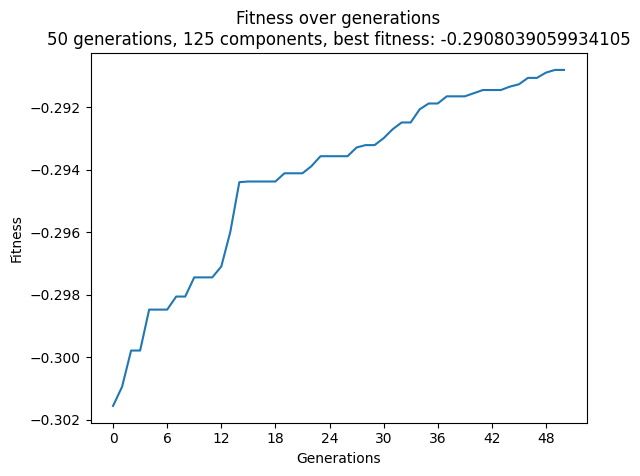

In [ ]:
pop_size = 100
fixed_components = 110
crossp = 0.9
mutp = 0.0001

generations = 50
n_best = 50
ga = fixed_size_GA(pop_size,fixed_components,crossp,mutp)
solution = ga.run(generations,n_best)[0]


In [17]:

df = pd.read_excel("datasets/Dataset_2.xlsx",sheet_name="preproc")
X = (df.iloc[:,14:]).values
y = (df.iloc[:,7]).values


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR


NRMSEPiqrscorer = make_scorer(NRMSEPiqr)



trials = 100
random_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials, replace= False)
ripartition = 0.25
final_results_pls = dict()


predictions_pls = []
result_NRMSEP_pls = []
NRMSE = []
total_time = 0
for i in range(trials):
    X_train, X_test, Y_train, Y_test = train_test_split(X[:, np.where(solution == 1)[0]], y, test_size=ripartition, random_state=seeds[i])
    pls = PLSRegression(n_components=59)
            
    start_time = time.time()
    pls.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds
        
    # Make predictions using the testing set
    Y_pred_pls = pls.predict(X_test)

        
    NRMSE.append(NRMSEPiqr(Y_test, Y_pred_pls))
    total_time+=elapsed_time



final_results_pls["Test size(%)"] =  str(ripartition *100 )
final_results_pls["Mean NRMSEPiqr"] = np.mean(NRMSE)
final_results_pls["Var NRMSEPiqr"] = np.var(NRMSE)
final_results_pls["Mean Training Time (sec)"] = total_time/trials
       


In [18]:
print(final_results_pls)

{'Test size(%)': '25.0', 'Mean NRMSEPiqr': np.float64(0.2908039059934105), 'Var NRMSEPiqr': np.float64(0.00020627963899058608), 'Mean Training Time (sec)': 0.038249104022979735}


In [19]:
waves = df.iloc[:,14:].columns[np.where(solution == 1)[0]]
print(waves)

with open(f"GA_Fixed_{fixed_components}c_25_Bands.txt","w") as f:
    f.write("Mean NRMSEPiqr:"+str(final_results_pls["Mean NRMSEPiqr"]) + ","+ "Var NRMSEPiqr:"+str(final_results_pls["Var NRMSEPiqr"]) + "," + "Mean Training Time (sec):"+str(final_results_pls["Mean Training Time (sec)"]))
    for wave in waves:
        f.write(str(wave)+"\n")

Index([ 387.5,  399.5,  407.5,  479.5,  487.5,  491.5,  515.5,  535.5,  559.5,
        571.5,
       ...
       2311.5, 2315.5, 2319.5, 2323.5, 2359.5, 2371.5, 2395.5, 2431.5, 2471.5,
       2491.5],
      dtype='object', length=125)
